In [136]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy.io import wavfile
from scipy import signal
import librosa

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

In [9]:
cwd = os.getcwd()
train_audio_path = cwd + '/speech_commands_v0.01'
filename = '/yes/b00c4c53_nohash_1.wav'
samples, sample_rate = librosa.load(str(train_audio_path)+filename)

In [216]:
class EDA:
    def __init__(self,directory_path):
        self.directory_path = directory_path
    
    def plot_histogram(self):
        dirs = [f for f in os.listdir(self.directory_path) if isdir(join(self.directory_path, f))]
        dirs.sort()
        number_of_recordings = []
        for direct in dirs:
            waves = [f for f in os.listdir(join(self.directory_path, direct)) if f.endswith('.wav')]
            number_of_recordings.append(len(waves))
        # Plot
        data = [go.Histogram(x=dirs, y=number_of_recordings)]
        trace = go.Bar(
            x=dirs,
            y=number_of_recordings,
            marker=dict(color = number_of_recordings, showscale=True
            ),
        )
        layout = go.Layout(
            title='Number of recordings in given label',
            xaxis = dict(title='Words'),
            yaxis = dict(title='Number of recordings')
        )
        py.iplot(go.Figure(data=[trace], layout=layout))
        
    def print_spectograms(self,subdirectories,count = float('inf')):
        for direct in subdirectories:
            waves = [f for f in os.listdir(join(self.directory_path, direct)) if f.endswith('.wav')]
            file_processors = []
            i = 0
            for f in waves:
                dir_name = self.directory_path + "/" + direct + "/"
                file_processor = FileProcessor(dir_name,f)
                file_processors.append(file_processor)
                file_processor.log_specgram()
                file_processor.plot_specgram()
                i = i + 1
                if(i >= count):
                    break

In [218]:
class FileProcessor:
    def __init__(self,dir_name,f_name):
        self.file_path = str(dir_name)+f_name
        self.sample_rate, self.samples = wavfile.read(str(dir_name) + f_name)
#         
        
    def log_specgram(self, window_size=20,
                 step_size=10, eps=1e-10):
        nperseg = int(round(window_size * self.sample_rate / 1e3))
        noverlap = int(round(step_size * self.sample_rate / 1e3))
        self.freqs, self.times, spec = signal.spectrogram(self.samples,
                                    fs=self.sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
        self.spec = np.log(spec.T.astype(np.float32) + eps)
        return self.spec

    def plot_specgram(self):
        fig = plt.figure(figsize=(14, 8))
        ax1 = fig.add_subplot(211)
        ax1.set_title('Raw wave of ' + filename)
        ax1.set_ylabel('Amplitude')

        ax1.plot(np.linspace(0, self.sample_rate/len(self.samples), self.sample_rate), self.samples)

        ax2 = fig.add_subplot(212)
        ax2.imshow(self.spec.T, aspect='auto', origin='lower', 
        extent=[self.times.min(), self.times.max(), self.freqs.min(), self.freqs.max()])
        ax2.set_yticks(self.freqs[::16])
        ax2.set_xticks(self.times[::16])
        ax2.set_title('Spectrogram of ' + self.file_path)
        ax2.set_ylabel('Freqs in Hz')
        ax2.set_xlabel('Seconds')
        
    def get_mel_spectogram(self):
        self.samples, self.sample_rate = librosa.load(self.file_path)
        S = librosa.feature.melspectrogram(self.samples, sr=self.sample_rate, n_mels=128)

        # Convert to log scale (dB). We'll use the peak power (max) as reference.
        self.log_S = librosa.power_to_db(S, ref=np.max)
        return self.log_S
    
    def plot_mel_spectogram(self):
        plt.figure(figsize=(12, 4))
        librosa.display.specshow(self.log_S, sr=self.sample_rate, x_axis='time', y_axis='mel')
        plt.title('Mel power spectrogram ')
        plt.colorbar(format='%+02.0f dB')
        plt.tight_layout()
    
    def get_delta(self):
        mfcc = librosa.feature.mfcc(S=self.log_S, n_mfcc=13)

        # Let's pad on the first and second deltas while we're at it
        self.delta2_mfcc = librosa.feature.delta(mfcc, order=2)
        return self.delta2_mfcc

    def plot_delta(self):
        plt.figure(figsize=(12, 4))
        librosa.display.specshow(self.delta2_mfcc)
        plt.ylabel('MFCC coeffs')
        plt.xlabel('Time')
        plt.title('MFCC')
        plt.colorbar()
        plt.tight_layout()

/Users/suryakanoria/Projects/Data_Science_Team_Project/TensorFlowSpeechRecognitionChallenge/speech_commands_v0.01


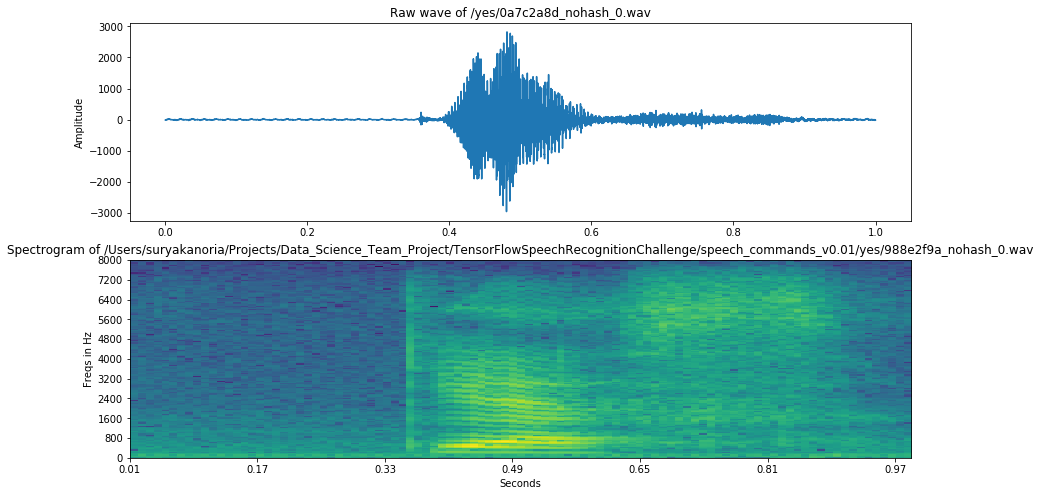

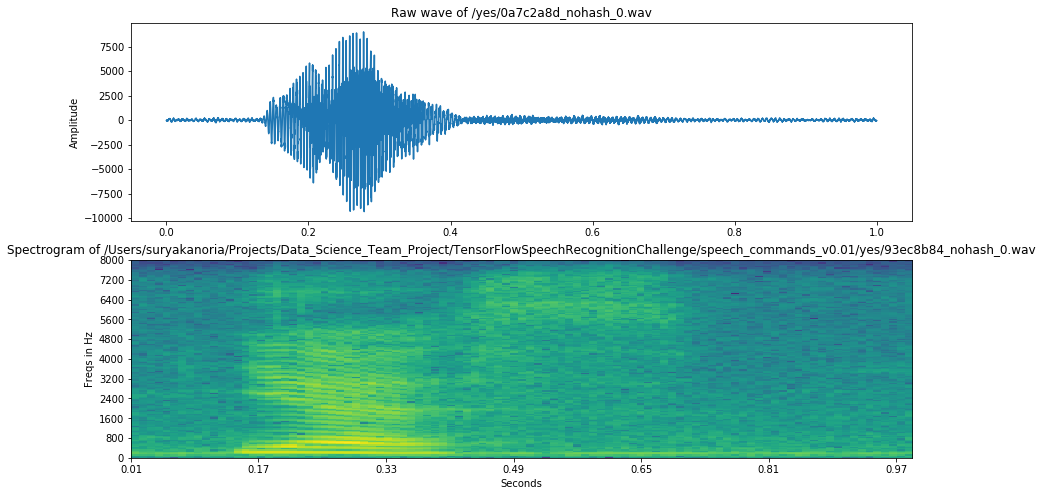

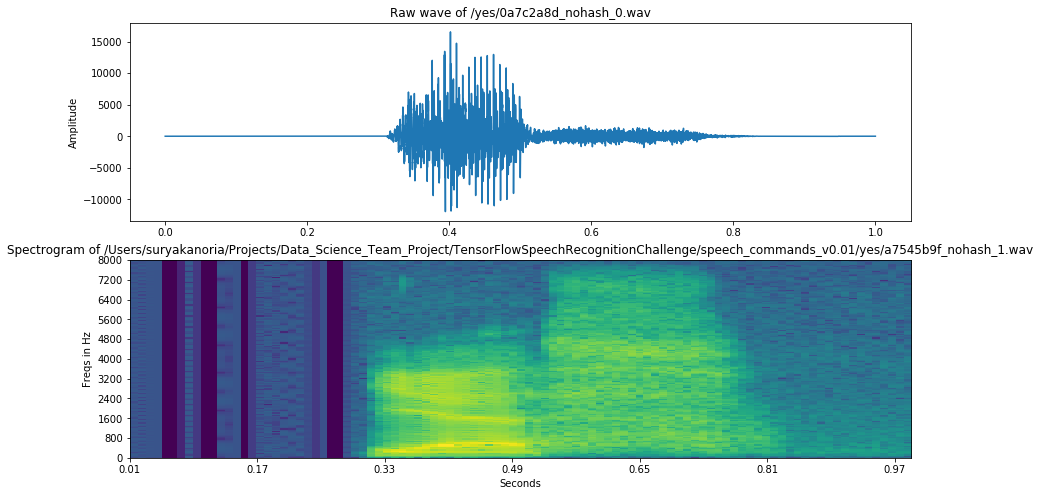

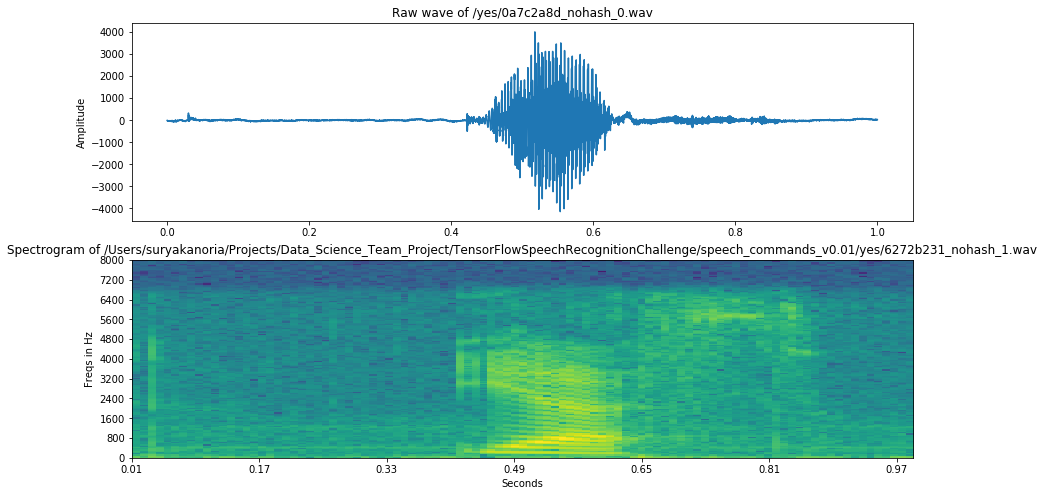

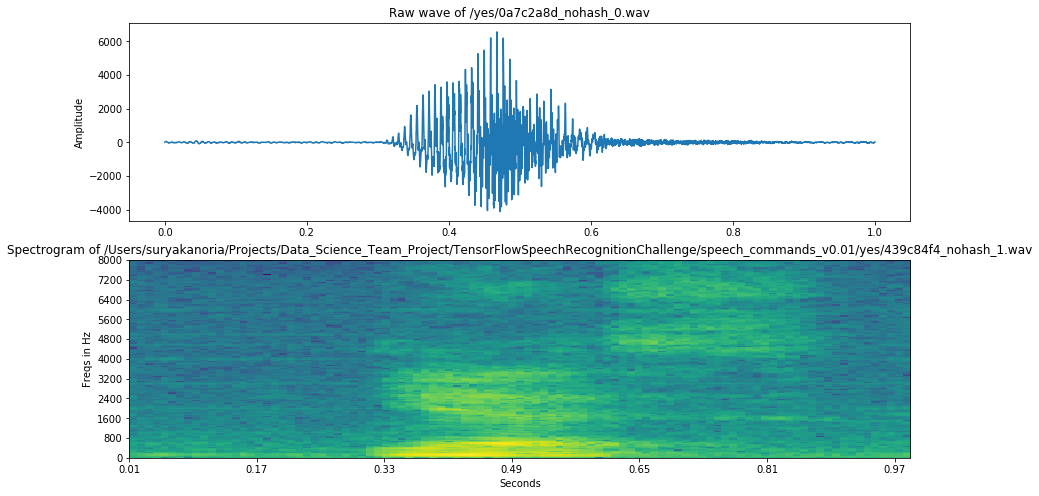

In [233]:
filename = '/yes/0a7c2a8d_nohash_0.wav'
print(train_audio_path)
eda = EDA(train_audio_path)
eda.plot_histogram()
eda.print_spectograms(["yes"],5)
# eda.print_spectograms(["go"],5)

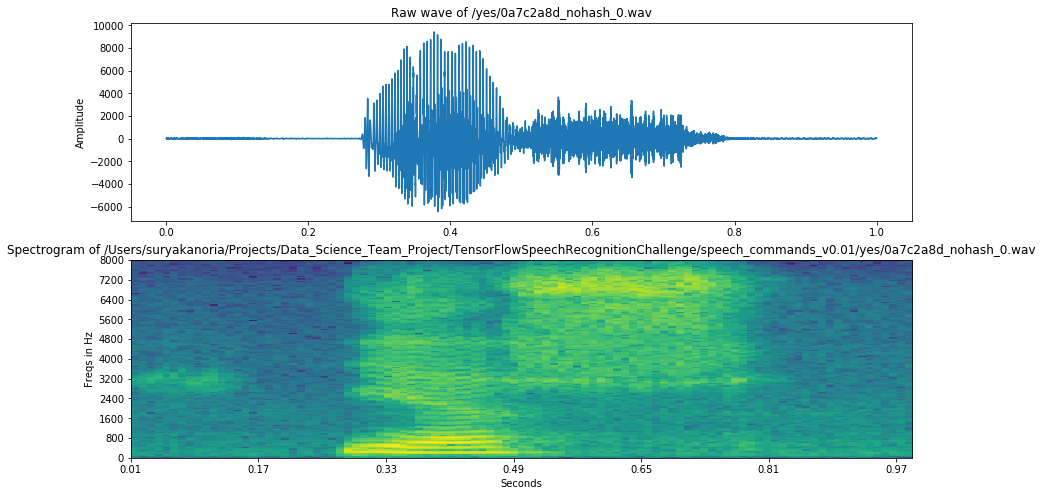

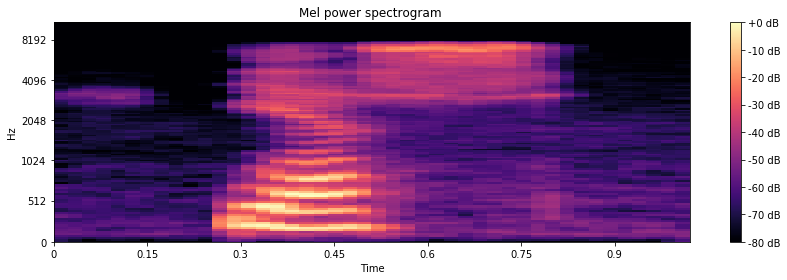

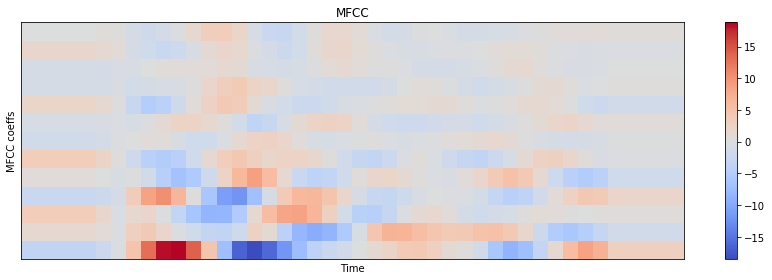

In [154]:
## Visualisation of yes
filename = '/yes/b00c4c53_nohash_1.wav'
file_processor = FileProcessor(train_audio_path,filename)
file_processor.log_specgram()
file_processor.plot_specgram()
file_processor.get_mel_spectogram()
file_processor.plot_mel_spectogram()
file_processor.get_delta()
file_processor.plot_delta()

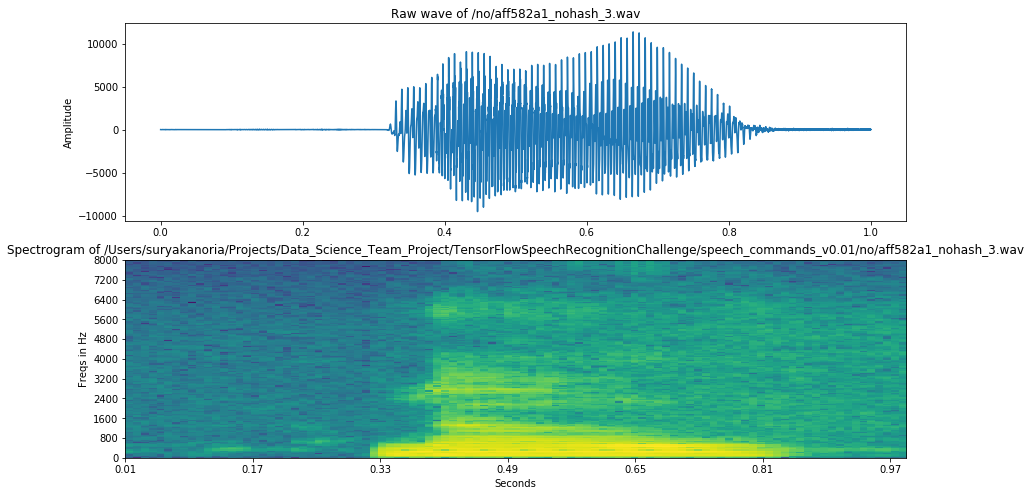

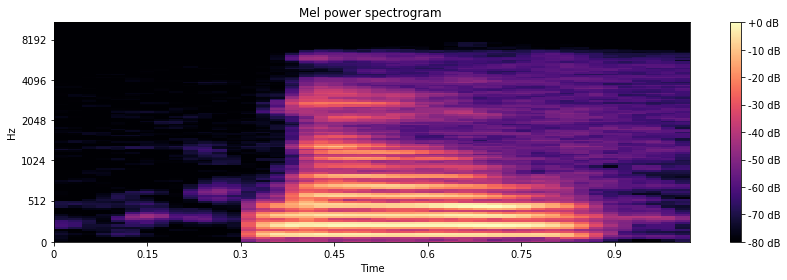

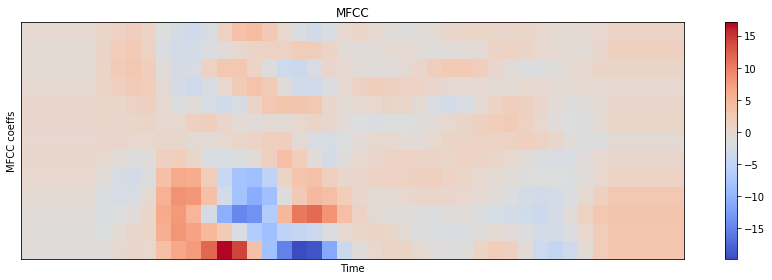

In [156]:
## Visualisation of no
filename = '/no/aff582a1_nohash_3.wav'
file_processor = FileProcessor(train_audio_path,filename)
file_processor.log_specgram()
file_processor.plot_specgram()
file_processor.get_mel_spectogram()
file_processor.plot_mel_spectogram()
file_processor.get_delta()
file_processor.plot_delta()

In [263]:
class DataLoader:
    def __init__(self,directory_path,subdirectories):
        self.directory_path = directory_path
        self.subdirectories = subdirectories
    
    def load(self):
        label = 0
        x = []
        y = []
        for direct in self.subdirectories:
            waves = [f for f in os.listdir(join(self.directory_path, direct)) if f.endswith('.wav')]
            file_processors = [FileProcessor(self.directory_path + "/" + direct + "/",f) for f in waves]
            
            mel_spectograms = [file_processor.log_specgram() for file_processor in file_processors]
            for mel_spectogram in mel_spectograms:
                x.append(mel_spectogram)
                y.append(label)
            
            label = label + 1
        return x,y
            

In [330]:
from keras.utils import to_categorical
train_audio_path = cwd + '/speech_commands_v0.01'
data_loader = DataLoader(train_audio_path,["yes","no"])
x,y = data_loader.load()
func = lambda temp: (temp.shape)[0]
length = max(map(func,x))
x=np.array([np.append(xi,np.ones([length - func(xi),(x[0].shape)[1]]),axis=0) for xi in x])
x_new_shape = (x.shape) + (1,)
x = x.reshape(x_new_shape)
y = to_categorical(y, num_classes=None, dtype='float32')


In [12]:
from keras.engine import Layer, InputSpec
from keras.layers import Flatten
import tensorflow as tf

class KMaxPooling(Layer):
    """
    K-max pooling layer that extracts the k-highest activations from a sequence (2nd dimension).
    TensorFlow backend.
    """
    def __init__(self, k=1, **kwargs):
        super().__init__(**kwargs)
        self.input_spec = InputSpec(ndim=3)
        self.k = k

    def compute_output_shape(self, input_shape):
        return (input_shape[0], (input_shape[2] * self.k))

    def call(self, inputs):
        
        # swap last two dimensions since top_k will be applied along the last dimension
        shifted_input = tf.transpose(inputs, [0, 2, 1])
        
        # extract top_k, returns two tensors [values, indices]
        top_k = tf.nn.top_k(shifted_input, k=self.k, sorted=True, name=None)[0]
        
        # return flattened output
        return Flatten()(top_k)

Using TensorFlow backend.


In [36]:
class Folding(Layer):

    def __init__(self, **kwargs):
        super(Folding, self).__init__(**kwargs)
        self.input_spec = InputSpec(ndim=3)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], int(input_shape[2]/2))

    def call(self, x):
        input_shape = x.get_shape().as_list()

        # split the tensor along dimension 2 into dimension_axis_size/2
        # which will give us 2 tensors
        splits = tf.split(x, num_or_size_splits=int(input_shape[2]/2), axis=2)

        # reduce sums of the pair of rows we have split onto
        reduce_sums = [tf.reduce_sum(split, axis=2) for split in splits]

        # stack them up along the same axis we have reduced
        row_reduced = tf.stack(reduce_sums, axis=2)
        return row_reduced

In [328]:
print(x.shape)

(4752, 99, 161)


In [333]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [332]:
from keras.models import Sequential
from keras.layers import Dense, Activation, ZeroPadding2D,Conv2D,Flatten,Conv1D,MaxPooling2D,BatchNormalization
from sklearn.metrics import roc_auc_score
import tensorflow as tf

def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)
model = Sequential([
    BatchNormalization(),
    ZeroPadding2D(padding=(3, 3)),
    Conv2D(10,(5, 7), padding="same",input_shape=(1,None,None)),
    Activation("relu"),
    Conv2D(10,(3, 3), padding="same",input_shape=x[0].shape),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid',),
    Conv2D(20,(3, 3), padding="same"),
    Activation("relu"),
    Conv2D(20,(3, 3), padding="same"),
    Activation("relu"),
#     Folding(),
    MaxPooling2D(pool_size=(3, 3), strides=None, padding='valid',),
    Flatten(),
    Dense(2, activation="softmax")
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train,y_train,validation_split=0.20, epochs=150, batch_size=100)

Train on 3801 samples, validate on 951 samples
Epoch 1/150
3801/3801 [==============================] - 86s 23ms/step - loss: 0.4305 - accuracy: 0.7943 - val_loss: 0.0952 - val_accuracy: 0.9632
Epoch 2/150
3801/3801 [==============================] - 83s 22ms/step - loss: 0.2769 - accuracy: 0.8882 - val_loss: 0.1420 - val_accuracy: 0.9527
Epoch 3/150
3801/3801 [==============================] - 87s 23ms/step - loss: 0.2072 - accuracy: 0.9190 - val_loss: 0.1349 - val_accuracy: 0.9474
Epoch 4/150
3801/3801 [==============================] - 84s 22ms/step - loss: 0.2239 - accuracy: 0.9124 - val_loss: 0.1225 - val_accuracy: 0.9579
Epoch 5/150
3801/3801 [==============================] - 85s 22ms/step - loss: 0.1477 - accuracy: 0.9463 - val_loss: 0.1690 - val_accuracy: 0.9369
Epoch 6/150
3801/3801 [==============================] - 84s 22ms/step - loss: 0.1274 - accuracy: 0.9547 - val_loss: 0.2072 - val_accuracy: 0.9243
Epoch 7/150
3801/3801 [==============================] - 84s 22ms/step 

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf

class DCNN:
    def __init__(self, sequence_lengths, sequence_length, num_classes, filter_sizes,filter_width, num_filters):
        '''
        Makes a new CNNClassifier
        Args:
            sequence_length: The length of each sentence
            num_classes: Number of classes in the output layer (positive and negative would be 2 classes)
            vocab_size: The size of the vocabulary, needed to define the size of the embedding layer
            embedding_size: Dimensionality of the embeddings
            filter_sizes: Number of words the convolutional filters will cover, there will be num_filters for each size
            specified.
            num_filters: The number of filters per filter size.

        Returns: A new CNNClassifier with the given parameters.
        '''

        # Define the inputs and the dropout
        print("SEQL")
        print(sequence_length)
        self.filter_sizes = filter_sizes
        self.num_filters = num_filters
        self.filter_width = filter_width
        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")
    
    def construct_model(self):
        pooled_outputs = []
        for i, filter_size in enumerate(self.filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                # Conv layer
                filter_shape = [filter_size, filter_width, 1, num_filters]
                # W is the filter matrix
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(
                    self.input_x,
                    W,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv"
                )

                # Apply nonlinearity
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")

                # Max-pooling layer over the outputs

                print(sequence_lengths[i] - filter_size + 1)
                print(h)

                pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, self.sequence_lengths[i] - self.filter_size + 1, 1, 1],
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="pool"
                )

                pooled = tf.reshape(pooled, [-1, 1, 1, self.num_filters])

                print(pooled)

                pooled_outputs.append(pooled)
                # Combine all of the pooled features
        num_filters_total = num_filters * len(filter_sizes)

        max_shape = tf.reduce_max(pooled_outputs, 1)
        print("shapes")
        print([p.get_shape() for p in pooled_outputs])

        # pooled_outputs = [tf.pad(p, [[0, int(max_shape.get_shape()[0]) - int(p.get_shape()[0])], [0, 0], [0, 0], [0, 0]]) for p in pooled_outputs]
        # pooled_outputs = [tf.reshape(p, [-1, 1, 1, num_filters]) for p in pooled_outputs]

        # pooled_outputs = [tf.reshape(out, [-1, 1, 1, self.max_length]) for out in pooled_outputs]

        self.h_pool = tf.concat(3, pooled_outputs)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])
        print("here")
        print(self.h_pool_flat)
        self.h_pool_flat = tf.reshape(self.h_pool, [max(sequence_lengths), num_filters_total])

        # Add dropout
        with tf.name_scope("dropout"):
            # casted = tf.cast(self.dropout_keep_prob, tf.int32)
            self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)
            self.h_drop = tf.reshape(self.h_drop, [-1, num_filters_total])

        # Do raw predictions (no softmax)
        with tf.name_scope("output"):
            W = tf.Variable(tf.truncated_normal([num_filters_total, num_classes], stddev=0.1), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            # xw_plus_b(...) is just Wx + b matmul alias
            self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name="scores")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")

        # Calculate mean cross-entropy loss
        with tf.name_scope("loss"):
            # softmax_cross_entropy_with_logits(...) calculates cross-entropy loss
            losses = tf.nn.softmax_cross_entropy_with_logits(self.scores, self.input_y)
            '''print("here")
            print(losses.get_shape())
            print(self.scores.get_shape())
            print(self.input_y.get_shape())'''
            self.loss = tf.reduce_mean(losses)

        # Calculate accuracy
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")

        # Combine all of the pooled features
        num_filters_total = num_filters * len(filter_sizes)

        max_shape = tf.reduce_max(pooled_outputs, 1)
        print("shapes")
        print([p.get_shape() for p in pooled_outputs])        

In [32]:
from tensorflow.contrib import learn

def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)

del_all_flags(tf.flags.FLAGS)
tf.flags.DEFINE_string("filter_sizes", "3,4,5", "Comma-separated filter sizes (default: '3,4,5')")
tf.flags.DEFINE_integer("num_filters", 10, "Number of filters per filter size (default: 128)")
tf.flags.DEFINE_float("dropout_keep_prob", 0.5, "Dropout keep probability (default: 0.5)")
tf.flags.DEFINE_float("l2_reg_lambda", 0.0, "L2 regularizaion lambda (default: 0.0)")

# Training parameters
tf.flags.DEFINE_integer("batch_size", 256, "Batch Size (default: 64)")
tf.flags.DEFINE_integer("num_epochs", 200, "Number of training epochs (default: 200)")
tf.flags.DEFINE_integer("evaluate_every", 100, "Evaluate model on dev set after this many steps (default: 100)")
tf.flags.DEFINE_integer("checkpoint_every", 100, "Save model after this many steps (default: 100)")

# Misc Parameters
tf.flags.DEFINE_boolean("allow_soft_placement", True, "Allow device soft device placement")
tf.flags.DEFINE_boolean("log_device_placement", False, "Log placement of ops on devices")

tf.app.flags.FLAGS.flag_values_dict()

{'filter_sizes': '3,4,5',
 'num_filters': 10,
 'dropout_keep_prob': 0.5,
 'l2_reg_lambda': 0.0,
 'batch_size': 256,
 'num_epochs': 200,
 'evaluate_every': 100,
 'checkpoint_every': 100,
 'allow_soft_placement': True,
 'log_device_placement': False}